## ４章のKeras版


## Policy Gradient Methods

In [1]:
import numpy as np
import random
from IPython.display import Image
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

# keras用のパッケージをインポート
import keras.layers as layers
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K

import gym

/usr/lib/sagemath/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/sagemath/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import seaborn as sns
import pandas as pd

def showResult(result, showOriginal=False):
    def running_mean(x, N=50):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)
    
    if showOriginal:
        d = pd.DataFrame(result)
    else:
        d = pd.DataFrame(running_mean(result))
    # loss,をプロット
    sns.set()
    d.plot()
    plt.show()

In [3]:
D_in, H, D_out = 4, 150, 2
learning_rate = 0.0009

# 例題がleakyReLUを使っているので、合わせる。
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import glorot_uniform

# 以下のURLを参照
# https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%202%20-%20Policy-based%20Agents%20with%20Keras.ipynb
# 中間層の情報を使って損失関数を定義し、評価用モデルと学習用モデルを使うところもすごい！
def createModel(learning_rate=learning_rate):
    inp = layers.Input(shape=(D_in,), name="input_x")
    adv = layers.Input(shape=(1,), name="advantages")
    x = layers.Dense(H, 
                     activation=LeakyReLU(), 
                     use_bias=False,
                     kernel_initializer=glorot_uniform(seed=42),
                     name="dense_1")(inp)
    out = layers.Dense(D_out, 
                       activation="softmax", 
                       use_bias=False,
                       kernel_initializer=glorot_uniform(seed=42),
                       name="out")(x)
    
    def custom_loss(y_true, y_pred):
        # pred is output from neural network, a is action index
        # r is return (sum of rewards to end of episode), d is discount factor
        return -K.sum(adv * K.log(y_pred)) # element-wise multipliy, then sum

    model_train = Model(inputs=[inp, adv], outputs=out)
    model_train.compile(loss=custom_loss, optimizer=Adam(lr=learning_rate))
    model_predict = Model(inputs=[inp], outputs=out)
    return model_train, model_predict

In [4]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    d_rewards = np.power(gamma,np.arange(lenr)) * rewards 
    d_rewards = (d_rewards - d_rewards.mean()) / (d_rewards.std() + 1e-07)
    return d_rewards

In [5]:
model_train, model_predict = createModel()
env = gym.make('CartPole-v0')
MAX_DUR = 200
MAX_EPISODES = 1000
gamma_ = 0.99
time_steps = []
durations = []
losses = []
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] # list of state, action, rewards
    
    for t in range(MAX_DUR): #while in episode
        act_prob = model_predict.predict(curr_state.reshape(1, D_in))[0]
        action = np.random.choice(np.array([0,1]), p=act_prob)
        prev_state = curr_state
        curr_state, reward, done, info = env.step(action)
        transitions.append((prev_state, action, reward))
        if done:
            durations.append(t)
            break

    # Optimize policy network with full episode
    ep_len = len(transitions) # episode length
    time_steps.append(ep_len)
    preds = np.zeros(ep_len)
    rewards = np.zeros(ep_len)
    states = []

    for i in range(ep_len): #for each step in episode
        state, action, reward = transitions[i]
        pred = model_predict.predict(state.reshape(1, D_in))[0]
        preds[i] = pred[action]
        rewards[i] = reward
        states.append(state)
    #
    discounted_rewards =  discount_rewards(rewards)
    states = np.array(states).reshape(ep_len, D_in)
    loss = model_train.train_on_batch([states, discounted_rewards] , preds)
    losses.append(loss)
        
env.close()

/usr/lib/sagemath/local/lib/python2.7/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


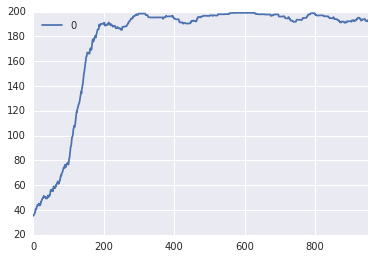

In [6]:
showResult(durations)

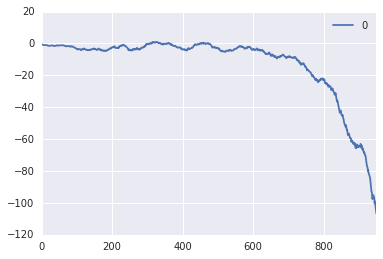

In [7]:
showResult(losses)

In [23]:
model_train.save_weights('models/param_train.hdf5')
model_predict.save_weights('models/param_predict.hdf5')

In [6]:
model_train, model_predict = createModel()
model_train.load_weights('models/param_train.hdf5')
model_predict.load_weights('models/param_predict.hdf5')

In [8]:
# from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [9]:
MAX_DUR = 200
env = gym.make('CartPole-v0')
state = env.reset()
frames = []
for t in range(MAX_DUR):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    act_prob = model_predict.predict(state.reshape(1, D_in))[0]b
    action = np.random.choice(np.array([0,1]), p=act_prob)
    print(action)
    state, reward, done, info = env.step(action)
    if done:
        break
env.render(close=True)
env.close()    

0
1
0
1
0
1
1
0
1
0
0
1
1
0
0
1
0
1
1
0
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
1
0
0
1
1
0
0
1
0
1
0
1
1
0
1
0
0
1
0
1
1
0
0
1
1
0
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
1
0
1
0
1
0
1
0
1
0
1
0
0
1
1
0
1
0
0


TypeError: render() got an unexpected keyword argument 'close'

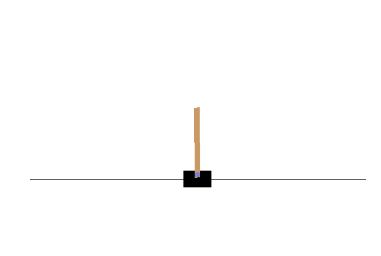

In [13]:
fig = plt.gcf()
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(fig, animate, frames = len(frames), interval=50)
anim.save("images/CartPole-v0.gif", writer = 'imagemagick')

<img src="images/CartPole-v0.gif" />

In [28]:
 D_in, H, D_out = 4, 150, 2
learning_rate = 0.0009

# 例題がleakyReLUを使っているので、合わせる。
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import glorot_uniform

# 以下のURLを参照
# https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%202%20-%20Policy-based%20Agents%20with%20Keras.ipynb
# 中間層の情報を使って損失関数を定義し、評価用モデルと学習用モデルを使うところもすごい！
def createModelB(learning_rate=learning_rate):
    inp = layers.Input(shape=(D_in,), name="input_x")
    adv = layers.Input(shape=(1,), name="advantages")
    x = layers.Dense(H, 
                     activation=LeakyReLU(), 
                     kernel_initializer=glorot_uniform(seed=42),
                     name="dense_1")(inp)
    out = layers.Dense(D_out, 
                       activation="softmax", 
                       kernel_initializer=glorot_uniform(seed=42),
                       name="out")(x)
    
    def custom_loss(y_true, y_pred):
        # pred is output from neural network, a is action index
        # r is return (sum of rewards to end of episode), d is discount factor
        return -K.sum(adv * K.log(y_pred)) # element-wise multipliy, then sum

    model_train = Model(inputs=[inp, adv], outputs=out)
    model_train.compile(loss=custom_loss, optimizer=Adam(lr=learning_rate))
    model_predict = Model(inputs=[inp], outputs=out)
    return model_train, model_predict

In [29]:
model_train, model_predict = createModelB()
env = gym.make('CartPole-v0')
MAX_DUR = 200
MAX_EPISODES = 1000
gamma_ = 0.99
time_steps = []
durations = []
losses = []
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] # list of state, action, rewards
    
    for t in range(MAX_DUR): #while in episode
        act_prob = model_predict.predict(curr_state.reshape(1, D_in))[0]
        action = np.random.choice(np.array([0,1]), p=act_prob)
        prev_state = curr_state
        curr_state, reward, done, info = env.step(action)
        transitions.append((prev_state, action, reward))
        if done:
            durations.append(t)
            break

    # Optimize policy network with full episode
    ep_len = len(transitions) # episode length
    time_steps.append(ep_len)
    preds = np.zeros(ep_len)
    rewards = np.zeros(ep_len)
    states = []

    for i in range(ep_len): #for each step in episode
        state, action, reward = transitions[i]
        pred = model_predict.predict(state.reshape(1, D_in))[0]
        preds[i] = pred[action]
        rewards[i] = reward
        states.append(state)
    #
    discounted_rewards =  discount_rewards(rewards)
    states = np.array(states).reshape(ep_len, D_in)
    loss = model_train.train_on_batch([states, discounted_rewards] , preds)
    losses.append(loss)
        
env.close()

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


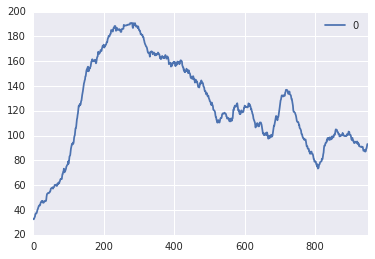

In [30]:
showResult(durations)

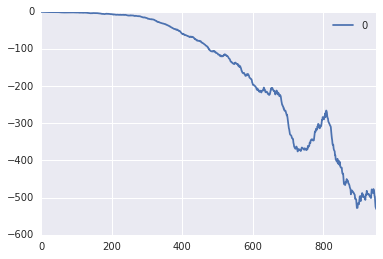

In [31]:
showResult(losses)